# U.S. Permanent Visa - Certified or Denied?

As of 2017, there were 45M immigrants or simply 13.5% of the population in USA constituted of immigrants, which is a lot in number. People migrate to USA to attain world class education, get jobs and make money as USA is believed to be one of the superpowers. There is a lot of analysis on why people migrated to USA done by Data Scientists, but for this exercise we three data geeks are concentrating on finding the criteria(s) that influences or could influence the Permanent Visa decision. We will use decision tree classification to understand what drives approval.

In this project we will be using U.S. permanent visa dataset.
`us_perm_visas.csv` data (Source: [Link](https://www.kaggle.com/jboysen/us-perm-visas/data)).

** Project Process Index:**

1. Data cleaning and preparation
2. Data exploration using pandas
    * What are the `Economic sectors` for which application are filed and which sector has the highest percentage of application
    * Which are the `Top 10 employer states` filing for the visa
    * What are the `Top 10 companies` mostly filing for the visa
    * What is the `Citizenship of employees` for which application is filed
    * What is the `Visa type` of the applications- this is the visa status at the time they enter US for the first time.
    * What is the `Education Background` of the applicants   
3. Finding-1
   * Due to 2010 recession, we assume that IT sector's permanent visa applications must have been affected the most and expect to see the higher rate of denials.
   * Conclusion of Finding-1
4. Finding-2
    * Is the visa approval rate for H-1B and F1 constant over the years?
    * Which are the 10 companies with highest denial rate
    * Is there any specific reason behind the company with highest denial rate? if yes then what it is?
    * Conclusion of Finding-2
5. Finding-3
    * We assume that permanent work visa must be tougher to get compared to H1B visa's, is it true?
    * Conclusion of Finding-3
6. Classification
    * Preprocessing the column using LabelEncoder
    * Developing the decision tree
    * Interpreting the decision tree
    * SMOTE analysis   
7. Conclusion 
8. Roadmap to Future

Reference:
* https://www.migrationpolicy.org/programs/data-hub/charts/immigrant-population-over-time

--------

## Importing necessary Packages & Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import sklearn as sk
import sklearn.tree as tree
import sklearn.preprocessing as pp
import sklearn.metrics as sm

import graphviz

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
#Certain warnings could not be solved, so they are ignored!
import warnings
warnings.filterwarnings('ignore')

In [3]:
visa = pd.read_csv('us_perm_visas.csv', low_memory=False,encoding='latin-1') 

You can download the Dataset from the following link 

- https://drive.google.com/file/d/1y7XABII6aKFkrwt0FrewUmAIuwXTuWbl/view?usp=sharing

In [4]:
print('Number of Visa Applications:', len(visa))
print('Number of Columns:', len(visa.columns))

Number of Visa Applications: 374362
Number of Columns: 154


We have very large amount of data in terms of characteristics of a record, with many irrelevant column for our analysis (explained below). Thus will just keep limited number of columns for further analysis

Our data is from 2011 - 2016 which is decent enough to do some analysis.

Now that we have seen the amount of data and the number columns, we are ready to start the cleaning of the data based on what we require.

Reference:
- https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython

------------

## Cleaning the dataset

#### Keeping relevant column for our analysis

In [5]:
visa_trans = visa[['case_no', 'case_number', 'case_status', 'class_of_admission', 'country_of_citizenship', 'country_of_citzenship', 'decision_date', 'employer_country', 'employer_name', 'employer_state', 'foreign_worker_info_education', 'naics_2007_us_title', 'pw_amount_9089', 'pw_unit_of_pay_9089', 'us_economic_sector']].copy()

We have chosen the above mentioned (in code) specific columns for various reasons.
* Many columns had only NaN values.
* Some columns had a small percentage of data and the rest was NaN. This might not add any relevance and they would not help with the analysis of the dataset or in training a model for prediction.
* Some columns has A, Y, N values and we could not find any detail of it online.

#### Cleaning Case Number

The case number values are split into two columns, `case_no` and `case_number`, hence we are going to blend the two columns.

In [6]:
visa_trans['case_no'].fillna(visa_trans['case_number'], inplace=True)

In [7]:
visa_trans=visa_trans.drop(['case_number'], axis=1)

In [8]:
visa_trans['case_no'].isnull().any()

False

We can see that there is no null values in this column. 

#### Cleaning H1-B values in class_of_admission column

In [9]:
visa_trans['class_of_admission'].unique()

array(['J-1', 'B-2', 'H-1B', 'L-1', 'EWI', 'E-2', 'E-1', 'H-2B', 'TPS',
       'F-1', 'B-1', 'C-1', 'Not in USA', 'TN', 'H-4', 'O-1', 'R-1',
       'L-2', 'Q', 'F-2', 'H-1B1', 'Parolee', 'G-5', 'E-3', 'H-2A', 'VWT',
       'P-1', 'A1/A2', 'D-1', 'A-3', 'R-2', 'H-1C', 'H-3', 'J-2', 'P-4',
       'I', 'H-1A', 'G-1', 'VWB', 'G-4', 'P-3', 'AOS/H-1B', 'O-3',
       'Parol', 'O-2', 'H1B', 'N', 'T-1', 'TD', 'M-1', 'K-1', 'U-1',
       'AOS', 'P-2', 'C-3', 'V-2', 'M-2'], dtype=object)

H-1B values are in the format "AOS/H-1B", "H1B" and hence we need to replace them to one format which we have chosen as "H-1B".

In [10]:
visa_trans['class_of_admission']=visa_trans['class_of_admission'].replace(['AOS/H-1B','H1B'],'H-1B')

We want to keep only those records which has visa type values in the `class_of_admission` column, for our analysis.

In [11]:
visa_trans = visa_trans[pd.notnull(visa_trans['class_of_admission'])]

#### Cleaning Decision Date

Converting the decision date in to datetime format for analysis.

In [12]:
visa_trans['decision_date']= pd.to_datetime(visa_trans['decision_date'],errors='coerce')

Creating a year column that only contains the year value from decision date for our year-year analysis.

In [13]:
visa_trans['year']=visa_trans['decision_date'].dt.year

Since we have created the year column and dont need the decision date column we will drop this.

In [14]:
visa_trans.drop(['decision_date'], axis=1,inplace=True)

#### Cleaning case_status Column

Checking for any null values in the case status column 

In [15]:
visa_trans['case_status'].isnull().any()

False

In [16]:
for value in visa_trans.case_status.unique():
    print(len(visa_trans[visa_trans['case_status'] == value])," occurrences of status '{}'".format(value))

171844  occurrences of status 'Certified'
21198  occurrences of status 'Denied'
142041  occurrences of status 'Certified-Expired'
16434  occurrences of status 'Withdrawn'


Since our dataset contains some records with status "Withdrawn", for our further analysis we will remove them from the dataset.

For the cases where status is "Certified" or "Certified-Expired" we will transform them to just one value "Certified" so that we will end up having only the desired value "Certified" and "Denied". 

In [17]:
visa_trans=visa_trans[visa_trans['case_status']!='Withdrawn']

In [18]:
visa_trans['case_status']=visa_trans['case_status'].replace(['Certified-Expired'],'Certified')

In [19]:
visa_trans['case_status'].unique()

array(['Certified', 'Denied'], dtype=object)

Reference:
* https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-certain-columns-is-nan

#### Cleaning employer state

In [20]:
visa_trans['employer_state'].isnull().sum()

26

There are only 26 null values for 'employer_state' in the records, so it is better to drop them for proper analysis

In [21]:
visa_trans.dropna(subset=['employer_state'],inplace=True)

Confirming the same below.

In [22]:
visa_trans['employer_state'].isnull().any()

False

#### Using a strip function to remove unwanted spaces & using map to feed data.

As there are over 300K records and its a string so we cannot say if there are whitespaces before or after the string value.

In [23]:
def cleanSpaces(x):
    x.strip()
    return x

In [24]:
visa_trans['employer_state'].map(cleanSpaces);

#### Conversion of States into abbriviation 

Many state values are in either full form or in abbreveation, so to maintain consistency we are converting all the full forms into abbreveation of states.

Reference:
* https://www.kaggle.com/kavyaa/us-visa-status-prediction-and-data-visualisation 

In [25]:
visa_trans['employer_state'].fillna('Unknown');

#Mapping from state name to short-form
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'Northern Mariana Islands':'MP', 
    'Palau': 'PW', 
    'Puerto Rico': 'PR', 
    'Virgin Islands': 'VI', 
    'District of Columbia': 'DC'
}

#Capitalizing Keys
us_state_abbrev = {k.upper(): v for k, v in us_state_abbrev.items()}
visa_trans['employer_state'].replace(us_state_abbrev, inplace=True);
visa_trans=visa_trans[visa_trans['employer_state']!='MARSHALL ISLANDS'];

Confirming the state values after transformation.

In [26]:
visa_trans['employer_state'].unique()

array(['NY', 'VA', 'FL', 'DE', 'NJ', 'GA', 'TX', 'KY', 'MS', 'MA', 'CA',
       'NC', 'WY', 'MO', 'WI', 'MD', 'PA', 'AZ', 'WA', 'CO', 'MN', 'OH',
       'NV', 'CT', 'IL', 'AL', 'OK', 'RI', 'DC', 'MI', 'IA', 'NH', 'IN',
       'SD', 'NE', 'KS', 'TN', 'PR', 'OR', 'AR', 'WV', 'SC', 'GU', 'VI',
       'LA', 'ID', 'ND', 'UT', 'HI', 'VT', 'ME', 'NM', 'AK', 'MT', 'MP',
       'GUAM', 'BRITISH COLUMBIA', 'BC'], dtype=object)


#### Cleaning Salary

Converting the salary of employee to yearly salary - Imputing the data of Yearly salary with median value of the salary column as we can see below that there are only 1643 null values in the whole of over 335K records and it will not affect the distribution much.

The reason for imputing is because we do not want to remove those records.

In [27]:
visa_trans['pw_amount_9089'].isnull().sum()

1643

In [28]:
#Calculating pay based on unit of pay and wage
di = {"Year": 1, "yr": 1, "Hour": 2080, "hr": 2080, "Week": 52, "wk": 52, "Bi-Weekly": 26,"bi": 26, "Month": 12, "mth": 12}
visa_trans['pw_unit_of_pay_9089'].replace(di, inplace=True)

#Changing datatype of pay to float
visa_trans['pw_amount_9089'] = visa_trans['pw_amount_9089'].str.replace(',', '')
visa_trans[['pw_amount_9089', 'pw_unit_of_pay_9089']] = visa_trans[['pw_amount_9089', 'pw_unit_of_pay_9089']].astype(float)
visa_trans['yearly_pay'] = visa_trans['pw_amount_9089']*visa_trans['pw_unit_of_pay_9089']
visa_trans['yearly_pay']=visa_trans['yearly_pay'].fillna((visa_trans['yearly_pay'].median()))


In [29]:
visa_trans.drop(['pw_amount_9089','pw_unit_of_pay_9089'], axis=1,inplace=True)


Reference:
* https://www.kaggle.com/kavyaa/us-visa-status-prediction-and-data-visualisation

#### Cleaning Education data

Checking for null values.

In [30]:
visa_trans['foreign_worker_info_education'].isnull().sum()

120674

As we dont want to remove all the records that are null, we will replace them by `Unknown` values.

In [31]:
visa_trans['foreign_worker_info_education'].fillna('Unknown', inplace=True)

#### Adding Region for every State

In US broadly we have four regions - 
* **Northeast** - Maine, New York, New Jersey, Vermont, Massachusetts, Rhode Island, Connecticut, New Hampshire, Pennsylvania
* **Midwest**- Illinois,Indiana,Iowa,Kansas,Michigan,Minnesota,Missouri,Nebraska,North Dakota,Ohio,South Dakota,Wisconsin
* **South**-Delaware, Florida, Georgia, Maryland, North Carolina, South Carolina, Virginia, West Virginia, Alabama, Kentucky, Mississippi,Tennessee,  Arkansas, Louisiana, Oklahoma,Texas,
* **West**- Montana, Wyoming, Colorado, New Mexico, Idaho, Utah, Arizona,Nevada, Washington, Oregon, California, Alaska, Hawaii

Reference:
* https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States

In [32]:
regions = {
    'ME':'Northeast', 
    'NY':'Northeast', 
    'NJ':'Northeast', 
    'VT':'Northeast',
    'MA':'Northeast',
    'RI':'Northeast',
    'CT':'Northeast',
    'NH':'Northeast',
    'PA':'Northeast',
    'IL':'Midwest',
    'IN':'Midwest',
    'IA':'Midwest', 
    'KS':'Midwest',
    'MI':'Midwest', 
    'MN':'Midwest', 
    'MO':'Midwest', 
    'NE':'Midwest',
    'ND':'Midwest', 
    'OH':'Midwest', 
    'SD':'Midwest', 
    'WI':'Midwest',
    'DE':'South',
    'FL':'South', 
    'GA':'South',
    'MD':'South',
    'NC':'South',
    'SC':'South',
    'VA':'South',
    'WV':'South',
    'AL':'South',
    'KY':'South',
    'MS':'South',
    'TN':'South',
    'AR':'South',
    'LA':'South', 
    'OK':'South',
    'TX':'South',
    'MT':'West',
    'WY':'West', 
    'CO':'West', 
    'NM':'West', 
    'ID':'West', 
    'UT':'West', 
    'AZ':'West', 
    'NV':'West',
    'WA':'West', 
    'OR':'West', 
    'CA':'West', 
    'AK':'West',
    'HI':'West',
    'DC':'Other', 
    'GUAM':'Other',
    'PR':'Other', 
    'MP':'Other', 
    'VI':'Other',
    'BRITISH COLUMBIA':'Other', 
    'GU':'Other', 
    'BC':'Other'
}

Below is a function to assign states to the region they belong in.

In [33]:
def get_region(state):
    return regions[state]

visa_trans['region'] = visa_trans['employer_state'].apply(get_region)

We only want to consider those records that belong in regions of the US for our analysis, thus removing the other region records.

In [34]:
visa_trans=visa_trans[visa_trans['region']!='Other']

Confirming that we have only four regions now.

In [35]:
visa_trans['region'].unique()

array(['Northeast', 'South', 'West', 'Midwest'], dtype=object)

#### Cleaning Country of Citizenship

Combining country of citizenship columns because the values are split into two columns. (Note: The two columns differ in spelling `i`).

In [36]:
visa_trans['country_of_citizenship'].fillna(visa_trans['country_of_citzenship'], inplace=True)

Dropping the unwanted `country_of_citzenship` column

In [37]:
visa_trans.drop(['country_of_citzenship'],axis=1);

##### With this, we have concluded our cleaning process and now moving on to exploration, analysis and interesting findings.

------------

## Description of the dataset

Each row is an applicant record for Permanent Visa Application. The columns report attributes for the applicant:

| Column | Description | 
|--------|-------------|
|`case_no`|Unique identifier assigned to each application submitted for processing to the ETA National Processing Center. A = Atlanta NPC; C = Chicago NPC |
|`case_status`| Status associated with the last significant event or decision.  Valid values include “Certified,” “Certified-Expired,” “Denied,” and “Withdrawn”|
|`class_of_admission`| If applicable, indicates the class of immigration visa the foreign worker held at the time the permanent labor certification application was submitted for processing.|
|`country_of_citizenship`|The Applicant's country of citizenship|
|`employer_country`| The country of employer| 
|`employer_name`|Name of the Employer| 
|`employer_state`| U.S state where Employer is based at. | 
|`foreign_worker_info_education`| Education background of the Employee - Masters, Bahelor's, Doctor's etc. | 
|`naics_2007_us_title`| NAICS classification of Job Title | 
|`us_economic_sector`| The Economic Sector in which the Applicant is working in | 
|`year`| The year when decision was taken | 
|`yearly_pay`| The yearly salary of the Applicant | 
|`region`| The region of Employer based on the state of the Employer |

--------------

## Visualization of the Dataset

In [38]:
visa_trans.case_status.value_counts()

Certified    312145
Denied        20898
Name: case_status, dtype: int64

In [39]:
(len(visa_trans[visa_trans['case_status']=='Denied'])/len(visa_trans)) * 100

6.274865407770168

It's interesting that about 6.3% of applications were denied which we assume is really low.

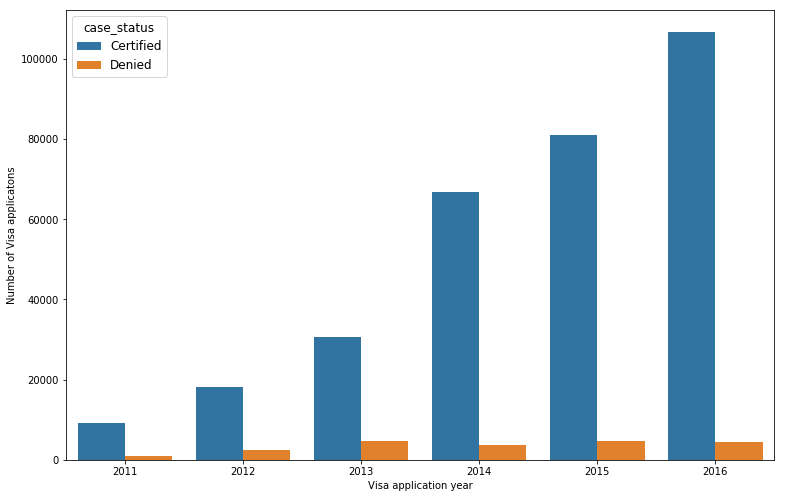

In [40]:
fig, ax = plt.subplots();
fig.set_size_inches(12.7, 8.27);
sns.set_context(rc={"font.size":12});
sns.countplot(x="year", hue="case_status", data=visa_trans);
ax.set(xlabel='Visa application year', ylabel='Number of Visa applicatons');

It's interesting that while the number of `Certified` applications increases, the number of `Denied` seems to be similar from year 2013.

---------------

## Data Exploration

We will analyze the nature of the applications- 

* What are the **Economic Sectors** for which application are filed and which sector has the highest percentage of application.
* Which are the **Top 10 Employer States** filing for the visa.
* What are the **Top 10 Companies** mostly filing for the visa.
* What is the **Citizenship of Employees** for which application is filed.
* What is the **Visa Type** of the applications- this is the visa status at the time they enter US for the first time.
* What is the **Education Background** of the applicants.

#### Application Percentage in various Economic sectors

In [41]:
#Creating empty dictionary
us_economic_counts = {}

#Iterating over "us_economic_sector" column and appending values to the "us_economic_counts" dictionary
for value in visa_trans['us_economic_sector'].dropna():
    if value in us_economic_counts:
        us_economic_counts[value] += 1
    else:
        us_economic_counts[value] = 1

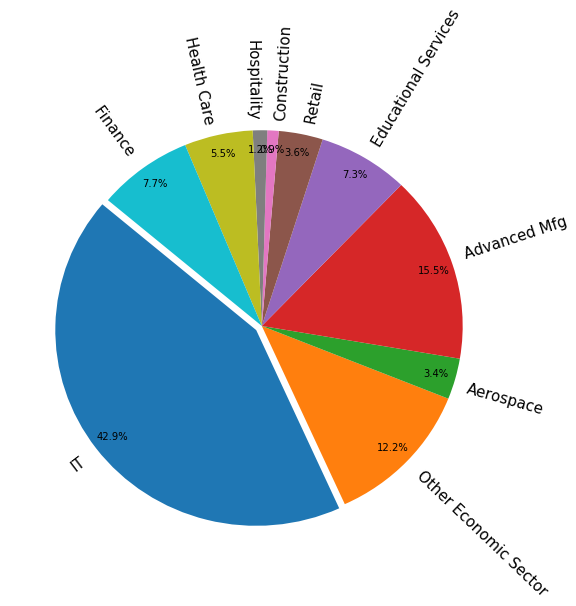

In [42]:
# Creating lists for us economic sectors and their counts
usecolabels = []
usecovalues = []
explode = (0.035, 0, 0, 0,0,0,0,0,0,0)

for key, value in us_economic_counts.items():
    usecolabels.append(key)
    usecovalues.append(value)
    
#Setting plot parameters
plt.figure(figsize=(9,9));  
sns.set_context(rc={"font.size":10,"axes.labelsize":30,"xtick.labelsize" : 15});
plt.pie(usecovalues[:10], labels=usecolabels[:10], explode = explode, autopct='%1.1f%%', pctdistance = 0.9,
          rotatelabels = 75, startangle=140, labeldistance = 1.05);

It confirms our assumption that most of the applicants belong to the IT sector.

Reference:
* https://www.kaggle.com/elzawie/us-permanent-visa-applications-v1-1

#### Top 10 States with the highest number of applications

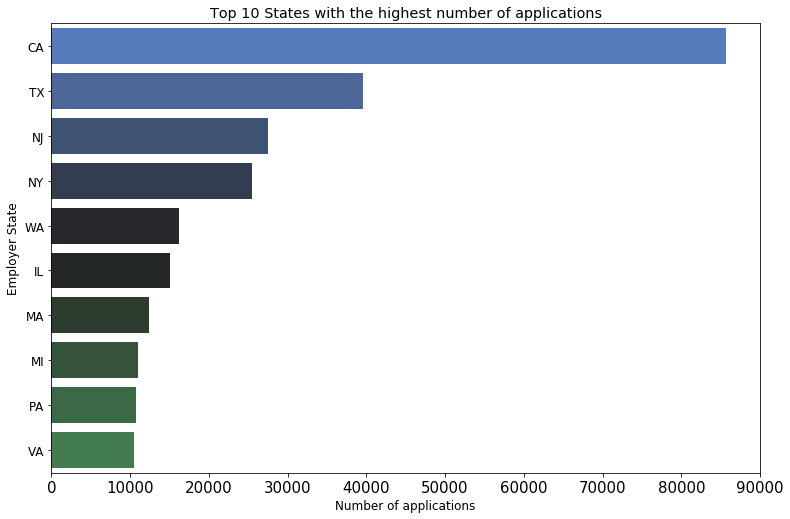

In [44]:
fig, ax = plt.subplots();
fig.set_size_inches(12.7, 8.27)
sns.countplot(y='employer_state', data=visa_trans, palette = sns.diverging_palette(255, 133, l=50, n=10, center="dark"),order=visa_trans.employer_state.value_counts().iloc[:10].index)
sns.set_context(rc={"font.size":12,"axes.labelsize":12})
plt.ylabel('Employer State');
plt.xlabel('Number of applications');
plt.title('Top 10 States with the highest number of applications');

As expected California has the highest number of applications, Since Bay Area, California is the IT hub.

#### Approval rate of applications per state

In [45]:
visa_state_status=pd.DataFrame(visa_trans.groupby(['employer_state','case_status'])['case_no'].agg(['count']).reset_index())

visa_state_ratio=(visa_state_status[visa_state_status['case_status']=='Certified'].groupby(['employer_state','case_status'])['count'].sum()/visa_state_status.groupby(['employer_state'])['count'].sum()).reset_index()

visa_state_ratio=visa_state_ratio.sort_values(by='count', ascending=False)

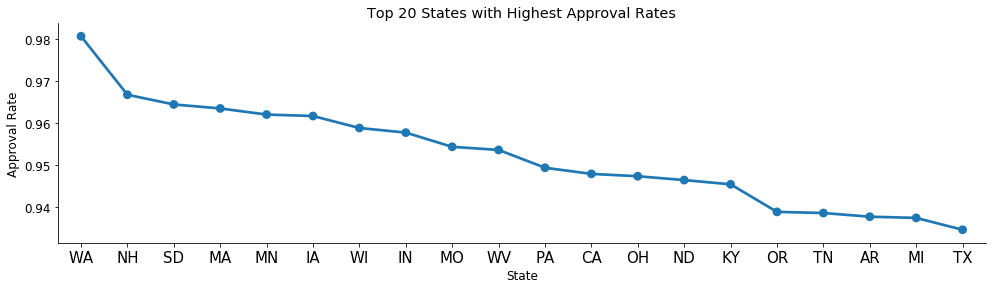

In [46]:
g=sns.factorplot(x="employer_state", y="count",data=visa_state_ratio.head(20), aspect=3.5); 
plt.title('Top 20 States with Highest Approval Rates');
plt.ylabel('Approval Rate');
plt.xlabel('State');

#### Top 10 Companies with the Highest number of applications

In [47]:
visa_trans.groupby('employer_name')['employer_name'].count().nlargest(10)

employer_name
COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION    11886
MICROSOFT CORPORATION                             8067
INTEL CORPORATION                                 6117
GOOGLE INC.                                       5057
AMAZON CORPORATE LLC                              3632
CISCO SYSTEMS, INC.                               2591
APPLE INC.                                        2531
ORACLE AMERICA, INC.                              2503
INFOSYS LTD.                                      2465
DELOITTE CONSULTING LLP                           1689
Name: employer_name, dtype: int64

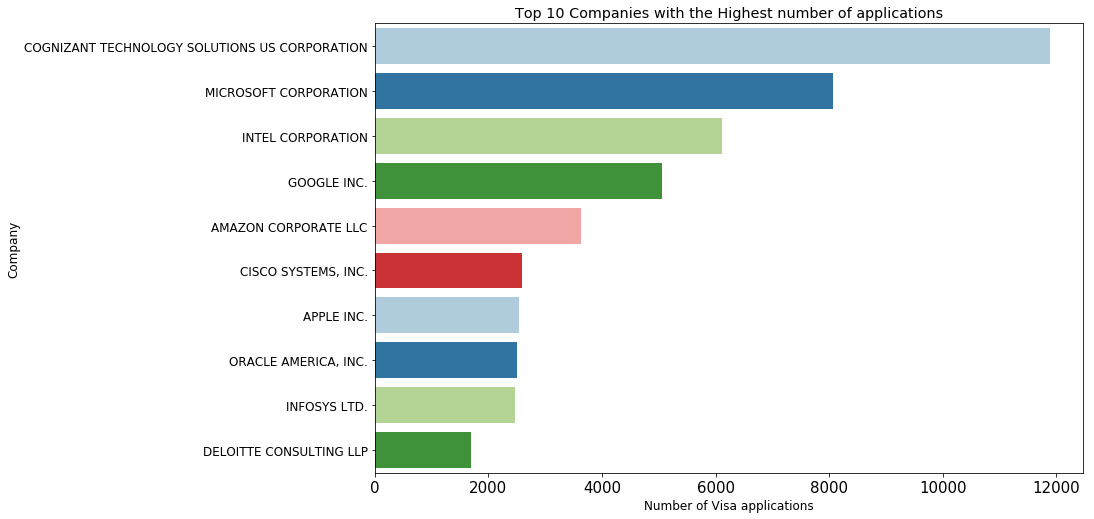

In [48]:
fig, ax = plt.subplots();
fig.set_size_inches(12.7, 8.27);
sns.set_context(rc={"font.size":12,"axes.labelsize":13});
sns.countplot(y='employer_name', data=visa_trans, palette =sns.color_palette("Paired"), order=visa_trans.employer_name.value_counts().iloc[:10].index);

ax.set(xlabel='Number of Visa applications', ylabel='Company');
plt.title('Top 10 Companies with the Highest number of applications');

As mentioned above most of the applciations are from the IT sector, so here we can see that the top 9 companies belong to that sector.

#### Top 10 occupations of applicants

In [49]:
visa_trans.groupby('naics_2007_us_title')['naics_2007_us_title'].count().nlargest(10)

naics_2007_us_title
Custom Computer Programming Services                3541
Colleges, Universities, and Professional Schools     957
Computer Systems Design Services                     815
Computer Systems Design and Related Services         581
Software Publishers                                  567
Engineering Services                                 518
Other Computer Related Services                      436
Elementary and Secondary Schools                     382
General Medical and Surgical Hospitals               363
Investment Banking and Securities Dealing            338
Name: naics_2007_us_title, dtype: int64

We can see that most applicants are Computer Programmers and Engineers.

#### Top 5 Countries of Citizenship

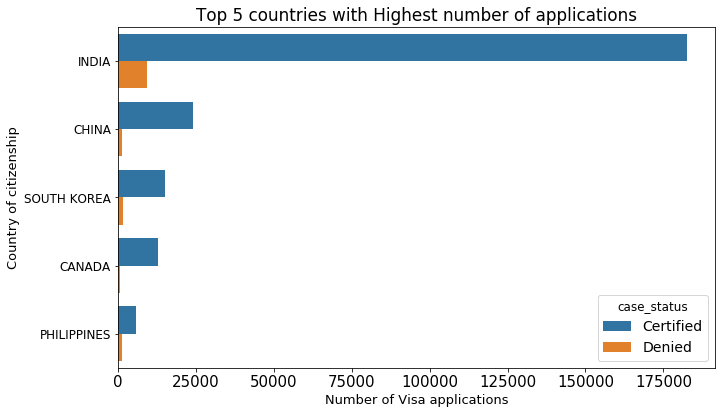

In [50]:
fig, ax = plt.subplots();
fig.set_size_inches(10.7, 6.27);
sns.set_context(rc={"font.size":14, "axes.labelsize":14});
sns.countplot(y='country_of_citizenship',hue='case_status',data=visa_trans, 
              order=visa_trans.country_of_citizenship.value_counts().iloc[:5].index);

ax.set(xlabel='Number of Visa applications', ylabel='Country of citizenship');
plt.title('Top 5 countries with Highest number of applications');

We can see most of the visa applicants are Indians.

#### Type of visa with which applicants entered USA

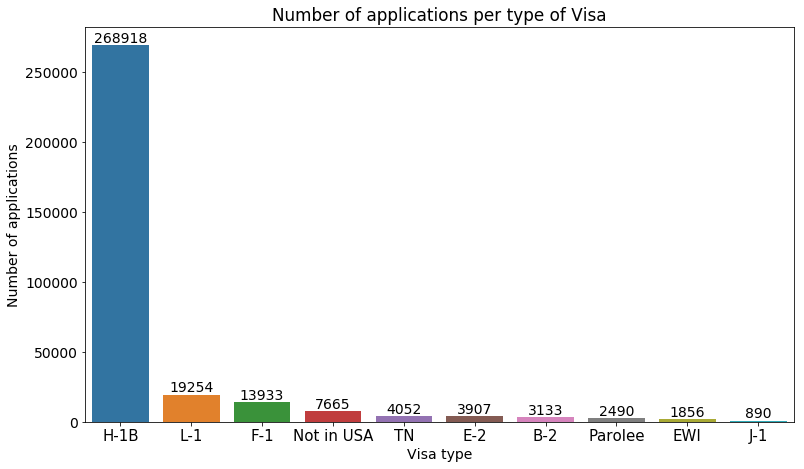

In [51]:
#Setting plot parameters
fig, ax = plt.subplots();
fig.set_size_inches(12.7, 7.27);
sns.countplot(x='class_of_admission',data=visa_trans, 
              order=visa_trans.class_of_admission.value_counts().iloc[:10].index);

#Iterating over elements in "class_of_admission" column and displaying counts above bars 
for i, v in visa_trans.class_of_admission.value_counts().head(10).reset_index().iterrows():
    ax.text(i,v.class_of_admission,v.unique()[1], horizontalalignment='center',verticalalignment='bottom');
    
ax.set(xlabel='Visa type', ylabel='Number of applications');
plt.title('Number of applications per type of Visa');

We can see most of the applicants who are applying for permanent work visa came to the states on H-1B. 

#### Education Background of the applicants

As we know already that many values in education column are unknown, thus we will ignore those records and see what other education background are there

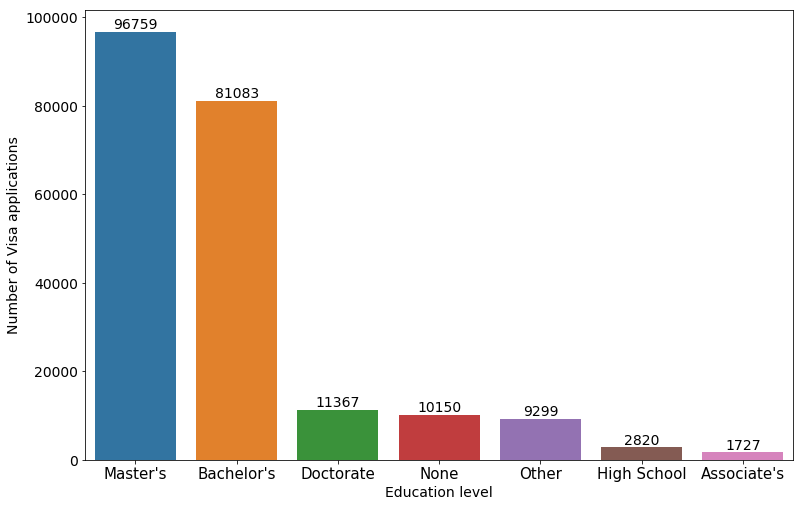

In [52]:
#Setting plot parameters
fig, ax = plt.subplots();
fig.set_size_inches(12.7, 8.27);
 #sns.set_context(rc={"font.size":14, "axes.labelsize":12})
sns.countplot(x='foreign_worker_info_education',data=visa_trans[visa_trans['foreign_worker_info_education']!='Unknown'], 
               order=(visa_trans[visa_trans['foreign_worker_info_education']!='Unknown']).foreign_worker_info_education.value_counts().iloc[:10].index);

#Iterating over elements in "job_info_job_title" column and displaying counts above bars 
for i, v in (visa_trans[visa_trans['foreign_worker_info_education']!='Unknown']).foreign_worker_info_education.value_counts().head(10).reset_index().iterrows():
    ax.text(i,v.foreign_worker_info_education,v.unique()[1], horizontalalignment='center',verticalalignment='bottom');

#Setting label titles    
ax.set(xlabel='Education level', ylabel='Number of Visa applications');
sns.set_context(rc={"font.size":12,"axes.labelsize":13});

#### Conclusion of Data Exploration

After our data exploration we can say that most of the applicants who majorly come from India and hold atleast a Bachelos's degree, work in the IT Sector and that's the reason most of the applications are filed by Employer's in California as this state is the IT hub.

--------------

## Interesting Findings

### First Finding

We know from common knowledge that in the year 2010, USA was hit bad with recession. Due to this, as we have seen since most of the applicants work in the IT sector, we assume that the rate of denials for this sector must have increased over the years since 2010. But is our assumption about IT sector true? Lets find out.


In [53]:
visa_trans_h1_f1=visa_trans[(visa_trans['class_of_admission']=='H-1B') | (visa_trans['class_of_admission']=='F-1') ]

We now Visualize the denial rates of applications based on Economic Sectors over the years 2011 - 2014 based on the available data for these years.

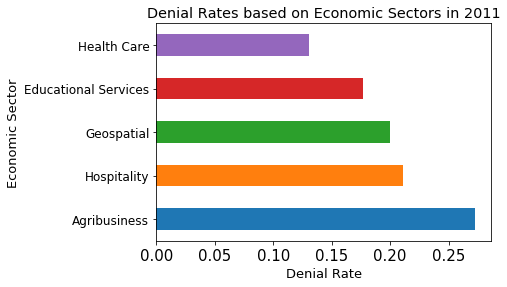

In [54]:
(visa_trans_h1_f1[(visa_trans_h1_f1['case_status'] == 'Denied') & (visa_trans_h1_f1['year'] == 2011)].groupby('us_economic_sector')['case_no'].count()\
/visa_trans_h1_f1[visa_trans_h1_f1['year'] == 2011].groupby('us_economic_sector')['case_no'].count()).nlargest(5).plot(kind='barh');
plt.xlabel("Denial Rate");
plt.ylabel("Economic Sector");
plt.title("Denial Rates based on Economic Sectors in 2011");

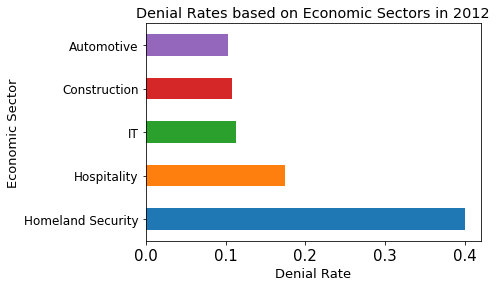

In [55]:
(visa_trans_h1_f1[(visa_trans_h1_f1['case_status'] == 'Denied') & (visa_trans_h1_f1['year'] == 2012)].groupby('us_economic_sector')['case_no'].count()\
/visa_trans_h1_f1[visa_trans_h1_f1['year'] == 2012].groupby('us_economic_sector')['case_no'].count()).nlargest(5).plot(kind='barh');

plt.xlabel("Denial Rate");
plt.ylabel("Economic Sector");
plt.title("Denial Rates based on Economic Sectors in 2012");

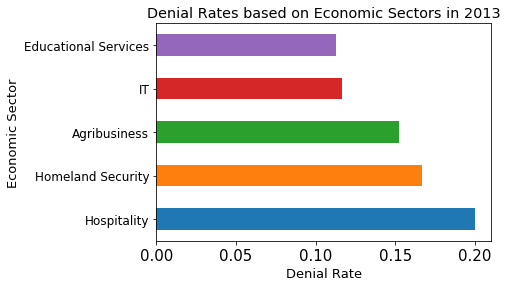

In [56]:
(visa_trans_h1_f1[(visa_trans_h1_f1['case_status'] == 'Denied') & (visa_trans_h1_f1['year'] == 2013)].groupby('us_economic_sector')['case_no'].count()\
/visa_trans_h1_f1[visa_trans_h1_f1['year'] == 2013].groupby('us_economic_sector')['case_no'].count()).nlargest(5).plot(kind='barh');

plt.xlabel("Denial Rate");
plt.ylabel("Economic Sector");
plt.title("Denial Rates based on Economic Sectors in 2013");

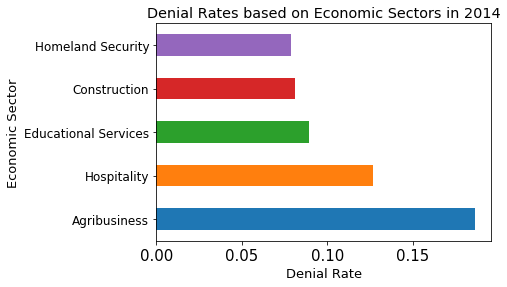

In [57]:
(visa_trans_h1_f1[(visa_trans_h1_f1['case_status'] == 'Denied') & (visa_trans_h1_f1['year'] == 2014)].groupby('us_economic_sector')['case_no'].count()\
/visa_trans_h1_f1[visa_trans_h1_f1['year'] == 2014].groupby('us_economic_sector')['case_no'].count()).nlargest(5).plot(kind='barh');
plt.xlabel("Denial Rate");
plt.ylabel("Economic Sector");
plt.title("Denial Rates based on Economic Sectors in 2014");

#### Conclusion

As mentioned above since 2010 recession, we assumed that the IT sector's permanent visa certifications had been affected the worst and expected to see the higher rate of denials, but for all the years since 2011, we have found that the economic sectors with the most denial rate are homeland security, agricultural business, hospitality. This was surprising because we did not expect something like homeland security to have filed applications in the first place and also have higher number of denials.
This goes against our assumption and also tells us that, if something like homeland security has a higher denial rate, then the decision is not biased and does not depend on this attribute.

### Second Finding

We are students who currently hold F1 visa and hence we are interested in the visa type **H-1B and F-1 Visa**. Also as seen above most number of applicants in this dataset entered USA on H-1B. 

So we assume here that the approval rate for applicants who entered USA for **H-1B and F-1 Visa** is constant over the years. Lets see what we find from this analysis.

In [58]:
visa_trans_h1_f1_status=pd.DataFrame(visa_trans_h1_f1.groupby(['year','class_of_admission','case_status'])['class_of_admission'].agg(['count']).reset_index())
pd.to_numeric(visa_trans_h1_f1_status['count'],downcast='float');


In [59]:
Visa_yearly_ratio=(visa_trans_h1_f1_status[visa_trans_h1_f1_status['case_status']!='Denied'].groupby(['year','class_of_admission'])['count'].sum()/visa_trans_h1_f1_status.groupby(['year','class_of_admission'])['count'].sum()).reset_index()

In [60]:
H1F1_visa=Visa_yearly_ratio.pivot(index='year', columns='class_of_admission', values='count')

Populating the interactive namespace from numpy and matplotlib


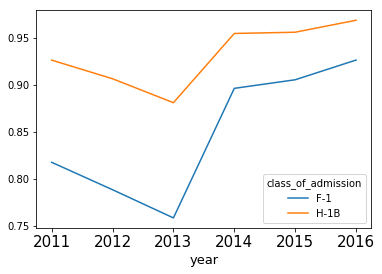

In [61]:
%pylab inline
H1F1_visa.plot();

Interesting to see that the acceptance rate for both these visa types has been declining since before 2011. As we mentioned above that in the year 2010 there was a recession. This could be a reason that we see a decline in the approval rates since before 2010 until 2013. But it would also be interesting to find out the which companies were affected mainly over these years.

#### Finding 10 companies with lowest approval rate

In [62]:
(visa_trans_h1_f1[(visa_trans_h1_f1['year'] == 2013) & (visa_trans_h1_f1['case_status'] == 'Certified')].groupby('employer_name')['employer_name'].count()\
/visa_trans_h1_f1[(visa_trans_h1_f1['year'] == 2013)].groupby('employer_name')['employer_name'].count()).nsmallest(10)

employer_name
INFOSYS TECHNOLOGIES LIMITED           0.014286
WIPRO LIMITED                          0.022222
ORACLE USA, INC.                       0.071429
GARLAND INDEPENDENT SCHOOL DISTRICT    0.076923
APEX TECHNOLOGY GROUP INC.             0.080000
GOLDMAN, SACHS & CO.                   0.111111
DATAMETRICS SOFTWARE SYSTEMS LLC       0.142857
GALAXY SOFTWARE SOLUTIONS INC.         0.142857
YASHRAJ TECHNOLOGIES INC               0.142857
DGN TECHNOLOGIES INC.                  0.152778
Name: employer_name, dtype: float64

We can see that Infosys has the lowest approval rate. Lets explore more about Infosys application in the years 2011-2015.

In [63]:
Infosys_df=pd.DataFrame((visa_trans_h1_f1[(visa_trans_h1_f1['employer_name'].str.contains("INFOSYS TECHNOLOGIES LIMITED")) & (visa_trans_h1_f1['case_status'] == 'Denied')].groupby(['year'])['case_no'].count())/(visa_trans_h1_f1[visa_trans_h1_f1['employer_name'].str.contains("INFOSYS TECHNOLOGIES LIMITED")].groupby(['year'])['case_no'].count())).reset_index()

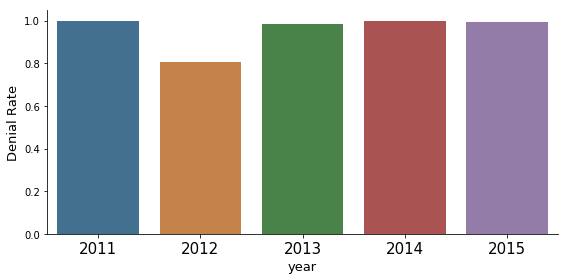

In [64]:
g=sns.factorplot(x="year", y="case_no",data=Infosys_df, saturation=.5,kind="bar",ci=None, aspect=2, legend=False);
plt.ylabel("Denial Rate");

We can see denial rate for permanent visa of employees working in Infosys is very high and mostly is 100%.

#### Conclusion

Interesting to know that, Jack Palmer a former employee of Infosys filed a case in Alabama in 2011, in the southern United States, that Infosys was illegally migrating employees from India on a business visa for conferences and that the company utilized this opportunity to satisfy their own technical needs in different projects by making the employees over stay and take over those job roles from H1B candidates. But this case was dismissed by the court due to lack of evidence. This later caught attention and in 2012 Federal prosecutors found that Infosys committed a systematic visa fraud and abuse. 
Due to which we assume that the USCIS took strict action post their settlement with the Federal prosecutors and have almost 100% denial rate. 

We also see that there is an increase in approval rate from 2013. This could also be because President Obama was inaugurated for a second term as president of the United States and also 2014 has been the strongest year of the U.S. labor market recovery which could also be because of the same reason. 

References:
* https://www.dawn.com/news/1053389

* http://money.cnn.com/2013/10/30/news/companies/infosys-immigration-settlement/

* http://profit.ndtv.com/news/corporates/article-who-is-infosys-whistleblower-jack-palmer-371036

* https://www.history.com/news/this-year-in-history-2013

* https://www.cfr.org/backgrounder/us-supreme-court-and-obamas-immigration-actions

* https://www.usnews.com/news/articles/2014/12/30/2014-the-us-economys-breakout-year

### Third Finding

We assume that permanent work visa must be tougher to get compared to H1B visa's, is it true?

Lets see which Visa has better approval rate? **H-1B** or **Permanent Visa** ?

#### H-1B Visa Application Import & Clean

We can get the `h1b_Visa.csv` data (Source: [Link](https://www.kaggle.com/msingh32/h1b-visa/data)).

This dataset is similar to the permanent visa dataset. Although, it only includes data for H-1B processing.

In [65]:
h1b_visa_df= pd.read_csv('h1b_Visa.csv', low_memory=False,encoding='latin-1') 

You can download the Dataset from the following link

- https://drive.google.com/file/d/1O-wfiH8jeHmF_RJWvkHgpHDTLr9emqiE/view?usp=sharing

In [66]:
h1b_visa_df=h1b_visa_df[(h1b_visa_df['CASE_STATUS']=='CERTIFIED-WITHDRAWN') | (h1b_visa_df['CASE_STATUS']=='CERTIFIED') | (h1b_visa_df['CASE_STATUS']=='DENIED') | (h1b_visa_df['CASE_STATUS']=='REJECTED')]

In [67]:
h1b_visa_df['CASE_STATUS']=h1b_visa_df['CASE_STATUS'].replace(['CERTIFIED-WITHDRAWN'],'CERTIFIED')
h1b_visa_df['CASE_STATUS']=h1b_visa_df['CASE_STATUS'].replace(['REJECTED'],'DENIED')
h1b_visa_df['YEAR']= h1b_visa_df['YEAR'].astype(int)

#### H-1B Visa application approval rate

In [68]:
h1b_visa_df_count=pd.DataFrame(h1b_visa_df.groupby(['YEAR','CASE_STATUS'])['CASE_STATUS'].agg(['count']).reset_index())
pd.to_numeric(h1b_visa_df_count['count'],downcast='float');

h1b_visa_approval_rate=(h1b_visa_df_count[h1b_visa_df_count['CASE_STATUS']!='DENIED'].groupby(['YEAR'])['count'].sum()/h1b_visa_df_count.groupby(['YEAR'])['count'].sum()).reset_index();

#### Permanent Visa approval rate 

In [69]:
total_visa=visa_trans
total_visa_count=pd.DataFrame(total_visa.groupby(['year','case_status'])['case_status'].agg(['count']).reset_index())
pd.to_numeric(total_visa_count['count'],downcast='float');

perm_visa_approval_rate=(total_visa_count[total_visa_count['case_status']!='Denied'].groupby(['year'])['count'].sum()/total_visa_count.groupby(['year'])['count'].sum()).reset_index();

#### Comparing approval rate of H-1B applications and Permanent Visa Applications

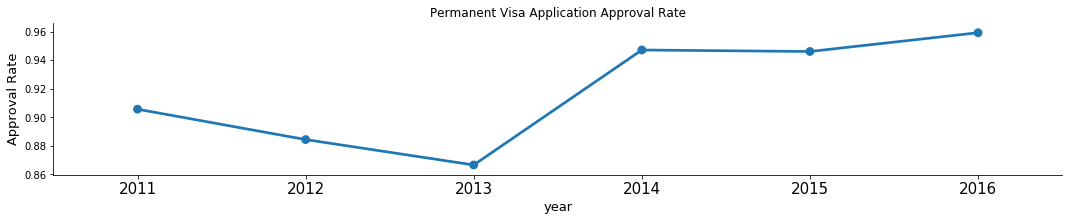

In [70]:
g=sns.factorplot(x="year", y="count",data=perm_visa_approval_rate, aspect=5, size=3); 
plt.title('Permanent Visa Application Approval Rate');
plt.ylabel('Approval Rate');

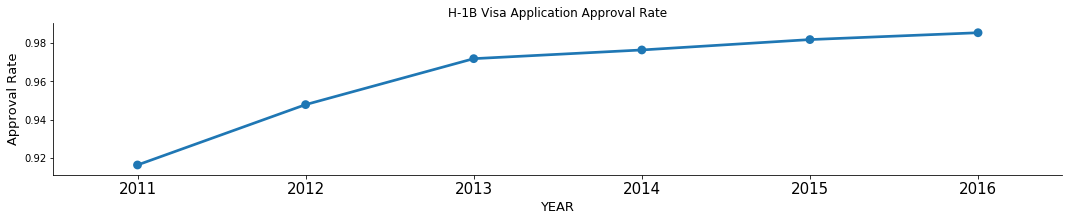

In [71]:
g=sns.factorplot(x="YEAR", y="count",data=h1b_visa_approval_rate, aspect=5, size=3); 
plt.title('H-1B Visa Application Approval Rate');
plt.ylabel('Approval Rate');

#### Conclusion

Interestingly, H-1B decisions doesn't seem to be affected as the permanent visa decision. There are many external factors that determine the approval rate of permanent visas, yet H-1B shows constant increase in approvals. This goes against our assumption, H-1B has better approval rate than permanent visa applications.

------------

## Decision Tree 

### Why use Supervised Learning?

Supervised learning is used when the 'Target' column is known in the dataset. Here, the target of the features(columns) is the `case_status` which determines if a permanent work visa has been Certified or Denied. Hence, using a supervised learning method is ideal and can help train a model based on the dataset to correctly predict the outcome of a Visa Application.



As mentioned above, we hold F-1 visa and hence we are interested to know the factors that affect the outcome of the decision tree for the **F-1 Visa**. So we are limiting our Decision Tree analysis to the F-1 visa type.

In [72]:
f1=visa_trans_h1_f1[visa_trans_h1_f1['class_of_admission']=='F-1']

The data is further filtered based on the years as we have education data only for these 3 years and we assume that this could be one of the features to determine the outcome of the Decision Tree. 

In [73]:
f1=f1[(f1['year']==2014) | (f1['year']==2015) | (f1['year']==2016)]

We are considering only the following set of features.

In [74]:
visa = f1[['case_status','employer_state','foreign_worker_info_education','year','country_of_citizenship','yearly_pay','region']]

### Pre-processing columns

As mentioned above, we are using the Decision Tree Classifier to train a model that can predict the outcome of a permanent work visa application. For this to happen, the categorical data must first be converted into numerical values for the model to be trained. Hence, pre-processing helps to achieve this conversion.

We are taking the features(columns) mentioned above as they are categorical data.

Preprocessing **case_status** Column

In [75]:
import sklearn.preprocessing as pp
le = pp.LabelEncoder()
visa['case_status'].unique()
visa.case_status = le.fit_transform(visa['case_status'].astype(str))

array(['Certified', 'Denied'], dtype=object)

In [76]:
visa['case_status'].unique()

array([0, 1], dtype=int64)

The `case_status` column has 2 unique values which have been pre-processed.

Preprocessing **employer_state** Column

In [77]:
le = pp.LabelEncoder()
visa['employer_state'].unique()
visa.employer_state = le.fit_transform(visa['employer_state'].astype(str))

array(['FL', 'WA', 'CA', 'VA', 'IL', 'NY', 'TX', 'LA', 'OH', 'CT', 'GA',
       'UT', 'MD', 'NJ', 'AZ', 'RI', 'MN', 'MI', 'ME', 'IA', 'NC', 'MO',
       'AL', 'NE', 'KY', 'HI', 'PA', 'IN', 'WI', 'VT', 'WV', 'NM', 'MA',
       'NV', 'TN', 'MT', 'AR', 'SC', 'KS', 'CO', 'MS', 'DE', 'ID', 'OR',
       'OK', 'NH', 'WY', 'SD', 'AK', 'ND'], dtype=object)

In [78]:
visa['employer_state'].unique()

array([ 8, 46,  4, 44, 13, 33, 42, 17, 34,  6,  9, 43, 19, 30,  3, 38, 22,
       21, 20, 11, 26, 23,  1, 28, 16, 10, 37, 14, 47, 45, 48, 31, 18, 32,
       41, 25,  2, 39, 15,  5, 24,  7, 12, 36, 35, 29, 49, 40,  0, 27],
      dtype=int64)

The `employer_state` column has 50 unique values which have been pre-processed.

Preprocessing **Region** Column

In [79]:
le = pp.LabelEncoder()
visa['region'].unique()
visa.region = le.fit_transform(visa['region'].astype(str))

array(['South', 'West', 'Midwest', 'Northeast'], dtype=object)

In [80]:
visa['region'].unique()

array([2, 3, 0, 1], dtype=int64)

The `region` column has four unique values which have been pre-processed.

Preprocessing **foreign_worker_info_education** Column

In [81]:
le = pp.LabelEncoder()
visa['foreign_worker_info_education'].unique()
visa.foreign_worker_info_education = le.fit_transform(visa['foreign_worker_info_education'].astype(str))

array(['Unknown', 'None', "Bachelor's", 'Doctorate', "Master's", 'Other',
       'High School', "Associate's"], dtype=object)

In [82]:
visa['foreign_worker_info_education'].unique()

array([7, 5, 1, 2, 4, 6, 3, 0], dtype=int64)

The `foreign_worker_info_education` column has several unique values which have been pre-processed.

Preprocessing **year** Column

In [83]:
le = pp.LabelEncoder()
visa['year'].unique()
visa.year = le.fit_transform(visa['year'].astype(str))

array([2014, 2015, 2016], dtype=int64)

In [84]:
visa['year'].unique()

array([0, 1, 2], dtype=int64)

The `year` column has three unique values which have been pre-processed.

Preprocessing **country of citizenship** Column

In [85]:
le = pp.LabelEncoder()
visa['country_of_citizenship'].unique()
visa.country_of_citizenship = le.fit_transform(visa['country_of_citizenship'].astype(str))

array(['VENEZUELA', 'INDIA', 'JAPAN', 'PHILIPPINES', 'SOUTH KOREA',
       'CHINA', 'IRAN', 'UKRAINE', 'PAKISTAN', 'RUSSIA', 'CANADA',
       'NEPAL', 'BANGLADESH', 'MALAYSIA', 'DOMINICAN REPUBLIC', 'CHILE',
       'URUGUAY', 'TURKEY', 'TAIWAN', 'BULGARIA', 'ITALY',
       'UNITED STATES OF AMERICA', 'BRAZIL', 'NIGERIA', 'SPAIN',
       'UNITED KINGDOM', 'PERU', 'SINGAPORE', 'EGYPT', 'POLAND',
       'COLOMBIA', 'INDONESIA', 'SRI LANKA', 'CZECH REPUBLIC', 'GAMBIA',
       'CAMEROON', 'GERMANY', 'ALBANIA', 'TRINIDAD AND TOBAGO', 'FRANCE',
       'NETHERLANDS', 'TURKMENISTAN', 'JORDAN', 'ETHIOPIA', 'THAILAND',
       'SOUTH AFRICA', 'SAUDI ARABIA', 'ECUADOR', 'MONGOLIA', 'GHANA',
       'VIETNAM', 'ISRAEL', 'ARGENTINA', 'GEORGIA', 'CYPRUS', 'AUSTRIA',
       'ARMENIA', 'ALGERIA', 'HONG KONG', 'LIBYA', 'EL SALVADOR',
       'LITHUANIA', 'MEXICO', 'ROMANIA', 'RWANDA', 'BURMA (MYANMAR)',
       'HONDURAS', 'SLOVAKIA', 'LEBANON', 'SYRIA', 'AZERBAIJAN', 'SERBIA',
       'SWEDEN', 'GUATEMALA',

In [86]:
visa['country_of_citizenship'].unique()

array([134,  59,  68,  98, 112,  31,  61, 129,  94, 102,  28,  89,  12,
        82,  40,  30, 132, 126, 120,  23,  65, 131,  21,  93, 113, 130,
        97, 108,  42,  99,  32,  60, 114,  37,  47,  27,  49,   1, 124,
        45,  90, 127,  69,  44, 123, 111, 105,  41,  87,  50, 135,  64,
         5,  48,  36,   8,   6,   2,  57,  77,  43,  78,  85, 101, 103,
        25,  56, 109,  76, 119,   9, 106, 117,  53,  86,  10,  84, 118,
        14,  95,  51, 115, 133,   0, 121, 138,  74,  67,  91,  38,  16,
        71,  24,  58, 139,  88,   7,  66, 137,  46,  80,  96,  19,  79,
        55,  63, 104, 100,  22, 122,  13,   4,  52,  15,  20, 107,  70,
        33, 128, 125,  81,  17, 136,  62,  92,  72,  29,  83,  35,  34,
        54,  75,  11, 110,  73,  26, 116,  39,  18,   3], dtype=int64)

The `country_of_citizenship` column has several unique values which have been pre-processed.

Processing **Yearly_salary** column

In [87]:
le = pp.LabelEncoder()
visa['yearly_pay'].unique()
visa.remuneration = le.fit_transform(visa['yearly_pay'].astype(str))

array([108493.,  86278.,  91988., ...,  84178., 110448., 113381.])

In [88]:
visa['yearly_pay'].unique()

array([108493.,  86278.,  91988., ...,  84178., 110448., 113381.])

The `yearly_pay` column has several unique values which have been pre-processed.

### Building the decision tree

We will Build and visualize a decision tree with depth of 1 (i.e., one root and two leaf nodes) to observe the basis with which the model has determines the outcome.

In [89]:
import sklearn as sk
from sklearn.tree import DecisionTreeClassifier

In [90]:
X = visa.drop(['case_status','employer_state','country_of_citizenship','year'], axis=1)
y = visa['case_status']

### Decision Tree with Depth as 1

In [91]:
dtc_visa_case_status=DecisionTreeClassifier(max_depth=1).fit(X,y)

### Plotting the decision tree of depth 1

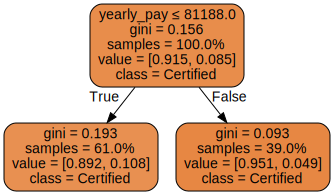

In [92]:
import graphviz
dot_data = tree.export_graphviz(dtc_visa_case_status, out_file=None, 
                         feature_names=list(X.columns),  
                         class_names =['Denied' if i == 1 else 'Certified' for i in dtc_visa_case_status.classes_] ,
                         filled=True,rounded=True,
                         special_characters=True,
                               proportion=True)  
graph = graphviz.Source(dot_data)  
graph 

The model with depth 1 doesn't give us much insight as it just says if your salary is either less than 80K or more than 80K dollars, your permanent visa acceptance probability is really high either 89.2% or 95.1% respectively. This information is not enough to make a decision. Hence we change the depth.

### Decision Tree with Depth 4

In [93]:
dtc_visa_case_status=DecisionTreeClassifier(max_depth=4).fit(X,y)

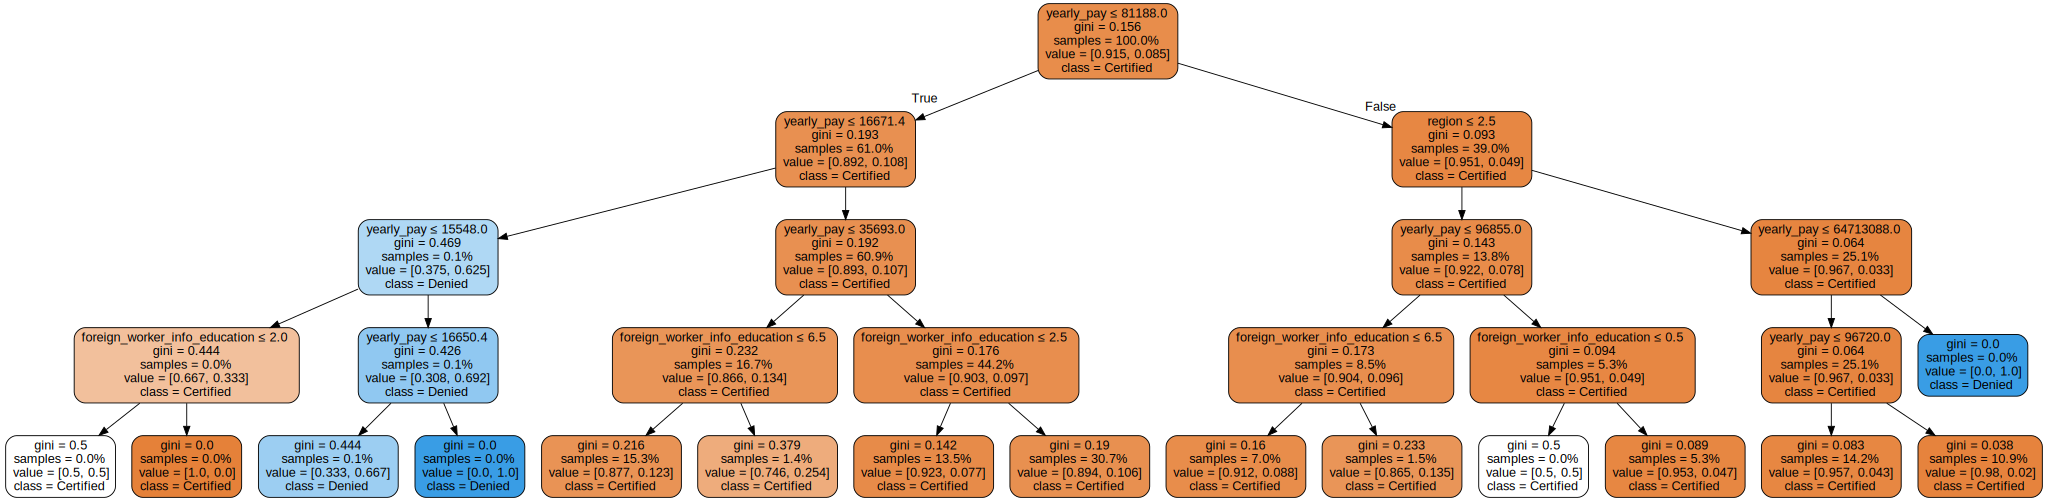

In [94]:
dot_data = tree.export_graphviz(dtc_visa_case_status, out_file=None, 
                         feature_names=list(X.columns),  
                         class_names =['Denied' if i == 1 else 'Certified' for i in dtc_visa_case_status.classes_] ,
                         filled=True,rounded=True,
                         special_characters=True,
                               proportion=True)  
graph = graphviz.Source(dot_data)  
graph 

This decision is a little better compared to the depth 1.
It gives us the following insights
* If your salary is less than 15.5K dollars and you have an Associate, Bachelor's or Doctorate degree then you are likely to be certified.
* If your salary is between 15.5 - 16.6K dollars and you have a High School, Associate, Bachelor's, Masters or Doctorate, you are likely to be denied.
* If you salary is between 36K - 82K dollars, then you are most likely to be certified.
* If you are in Northeast, Midwest or South and have a salary between 82 - 97K dollars, you are most likely to be certified.
* If you are in the west, you are most likely to be certified.


#### Outliers

Based on salary there are a few outliers we have noticed. 
* There are a few values as less as 10 dollars which is a yearly income.
* And then there are few values as high as 64 million dollars as yearly income.

## Random Forests & SMOTE analysis


### Why Random Forests?

The decision tree as shown above doesn't provide a clear classification result when applied to the dataset. Although it may have a good accuracy score, there is a great chance that the data for the model is overfitted while training the model and this would mean that the model might be biased towards a specific class. This can be avoided by the use of Random Forest Classifier. A Random Forest builds a collection of several decision trees that individual predict the class of the target variable and then use a voting mechanism to determine the prediction class of the target variable  accurately. Here, we use several decision trees to make up the random forest and build the model. Thus, the overfitting of a dataset is prevented. 

### Imabalanced Dataset & How to deal with it

As we are dealing with an Imbalanced dataset, it becomes tough for the classifier (either a decision tree or a random forest classifier) to properly classify the data into their respective classes.

This imbalance in the dataset could be dealt with by either over-sampling the minority class or under-sampling the majority class of the dataset. We use both these types of sampling techniques and compare it with the normal classification to determine which is better and based on what factors.

The algorithms chosen for these classfications are SMOTE (Synthetic Minority class Over-sampling technique), to over-sample the minority class (Denied) and Near-Miss classification in which the majority class (Certified) is undersampled to match the frequency of the minority class(Denied).

In [95]:
from collections import Counter
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [96]:
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f1: {}".format(f1_score(true_value, pred)))

In [97]:
visa_SMOTE = visa.drop(['case_status'],axis=1)

In [98]:
# our classifier to use
classifier = RandomForestClassifier

# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(visa.drop(['case_status'],axis=1), visa['case_status'], random_state=2)


# build normal model
pipeline = make_pipeline(classifier(random_state=42))
model = pipeline.fit(X_train, y_train)
prediction = model.predict(X_test)

# build model with SMOTE imblearn
smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), classifier(random_state=42))
smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

# build model with undersampling
nearmiss_pipeline = make_pipeline_imb(NearMiss(random_state=4), classifier(random_state=42))
nearmiss_model = nearmiss_pipeline.fit(X_train, y_train)
nearmiss_prediction = nearmiss_model.predict(X_test)


# print information about both models
print()
print("normal data distribution: {}".format(Counter(visa['case_status'])))
X_smote, y_smote = SMOTE().fit_sample(visa_SMOTE, visa['case_status'])
print("SMOTE data distribution: {}".format(Counter(y_smote)))
X_nearmiss, y_nearmiss = NearMiss().fit_sample(visa_SMOTE, visa['case_status'])
print("NearMiss data distribution: {}".format(Counter(y_nearmiss)))

# classification report
print(classification_report(y_test, prediction))
print(classification_report_imbalanced(y_test, smote_prediction))

print()
print('normal Pipeline Score {}'.format(pipeline.score(X_test, y_test)))
print('SMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))
print('NearMiss Pipeline Score {}'.format(nearmiss_pipeline.score(X_test, y_test)))


print()
print_results("normal classification", y_test, prediction)
print()
print_results("SMOTE classification", y_test, smote_prediction)
print()
print_results("NearMiss classification", y_test, nearmiss_prediction)


normal data distribution: Counter({0: 11147, 1: 1040})
SMOTE data distribution: Counter({0: 11147, 1: 11147})
NearMiss data distribution: Counter({0: 1040, 1: 1040})
             precision    recall  f1-score   support

          0       0.92      0.98      0.95      2761
          1       0.38      0.13      0.19       286

avg / total       0.87      0.90      0.88      3047

                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.95      0.19      0.93      0.42      0.19      2761
          1       0.28      0.19      0.95      0.23      0.42      0.17       286

avg / total       0.86      0.88      0.26      0.87      0.42      0.19      3047


normal Pipeline Score 0.8989169675090253
SMOTE Pipeline Score 0.8792254676731212
NearMiss Pipeline Score 0.3386937971775517

normal classification
accuracy: 0.8989169675090253
precision: 0.3829787234042553
recall: 0.1258741258741259
f1: 0.18947368421052632

SMOTE classification
acc

### Analysis of the Results :

By analysis of the results it is understood that although the classification of the un-sampled model has a better accuracy than the other sampled models the Recall and F1 scores are pretty low. This is due to the nature of the dataset which is imbalanced. 
 * The precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
 * Recall is the ratio `tp / (tp + fn)` where `fn` the number of false negatives. The Recall is intuitively the ability of the classifier to find all the positive samples. 
 * The F1 score can be interpreted as a weighted harmonic mean of the precision and recall with 1 = best and 0 = worst. `f1` means that recall and precision have equal weight.

The SMOTE classification has the best values for Recall and F1 scores. Based on the results, the Recall value for the normal classification is very low which means that the classifier is unable to determine the class of the target variable properly. This might be due to the lesser number of records for the 'Denied' class which affects the decision making of the classifier. The Recall values of the SMOTE analysis is better because there are larger samples of data for the minority class, so the classifier does a better job at predicitng the target class correctly. Near Miss classification has a higher Recall score but the precesion of the classification is appalling, as the total number of samples is significantly reduced due to under-sampling.

Another reason for the low scores even after applying SMOTE Analysis could be that the dataset after cleaning and filtering for F-1 visa applications has lower number of records. With a larger number of records the scores will show further improvement.


Reference:
- http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

- https://www.youtube.com/watch?v=DQC_YE3I5ig

- https://www.youtube.com/watch?v=FheTDyCwRdE

- https://github.com/coding-maniac/over-under-sampling/blob/master/src/main.py

--------------

## Conclusion

Most of the Certified applicants:
* Stayed in California
* Work in the IT sector
* Have atleast a Bachelor's Degree
* General salary Range 60 - 120K dollars

In conclusion, there is not one feature/factor/attribute which acts as a deciding factor in either Certifying or Denying a permanent visa application.
There are additional features which might play a significant role in determining the outcome of a visa application (below mentioned in future roadmap).


----------------


## Roadmap for the Future

Based on the Analysis of the data, a few elements could be improved as the model training part of the analysis was severly affected by the imbalanced nature of the dataset.

* More Features
    - Based on the above analysis of the permanent visa applications, we understand that there might be several reasons which play a significant role in determining if the application would be 'Certified' or 'Denied'. These might include but not be limited to Criminal History, Credit Score, Tax Returns and even the Visa Interview. So, in addition to all the factors taken into consideration such as the employer details, salary details, year of application etc. external factors also need to be considered to accurately determine if the application is 'Certified' or 'Denied'. This would mean that more data in form of features would help any model be trained better.


* GridSearch & XGBoost
    - The supervised learning methods used, could not properly classify the minority class of the dataset which was the 'Denied' application data. This was mainly due to the imbalanced nature of the dataset and hence, the decision tree could not properly classify the dataset based on the features provided. Although the F1 and recall scores had improved by the use of SMOTE analysis, it is an appalling value for a model to have. This still has lot of room for improvement and techniques such as GridSearch, to select the best features or even the best classification technique to build the model, could be used for building a better model which would have better F1 and recall scores maintaining the accuracy and precision of the current models. 
    
    - XGBoost as a model could be used to improve the performance of the model as it employs an ensemble of decision trees and improves its decision over each iteration of individual decision trees.

-----------